# Pipeline for the anomaly detection on the SKAB using LSTM-VAE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../utils')

## Data loading

In [2]:
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [4]:
df = list_of_df[0]
for i in range(1, len(list_of_df)):
    pd.concat()

TypeError: concat() missing 1 required positional argument: 'objs'

## Labels

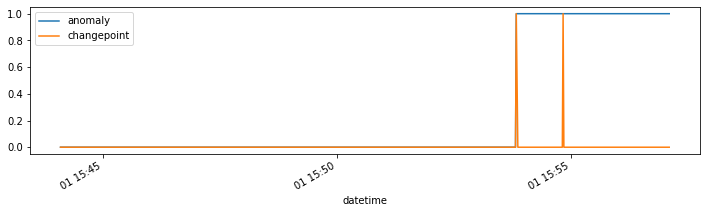

In [10]:
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [11]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.signal import medfilt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [12]:
def Random(seed_value):
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [13]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std):
    x = Input(shape=(timesteps, input_dim,))

    h = LSTM(intermediate_dim)(x)

    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)
    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded)
    vae = Model(x, x_decoded_mean)
    encoder = Model(x, z_mean)
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    def vae_loss(x, x_decoded_mean):
        mse = losses.MeanSquaredError()
        xent_loss = mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    return vae, encoder, generator

In [14]:
def arch(data):
    Random(0)
    
    input_dim = data.shape[-1]
    timesteps = data.shape[1]
    BATCH_SIZE = 1
    
    model, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=BATCH_SIZE, 
        intermediate_dim=32,
        latent_dim=100,
        epsilon_std=1.)

    history = model.fit(
        data,
        data,
        epochs=20,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1
    )
    return history, model

### Training in the beginning of each dataset

In [15]:
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [57]:
N_STEPS = 10
Q = 0.999
predicted_outlier, predicted_cp = [], []
for df in tqdm(list_of_df, desc='1st loop'):
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    history, model = arch(X)
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    UCL = residuals.quantile(Q)
    
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    anomalous_data = cnn_residuals > (3/2 * UCL)
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    predicted_outlier.append(prediction)
    
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

1st loop:   0%|          | 0/34 [00:00<?, ?it/s]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 16s 23ms/sample - loss: 0.7565 - val_loss: 0.7175
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6770 - val_loss: 0.6870
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6575 - val_loss: 0.6642
Epoch 4/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6462 - val_loss: 0.6667
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6398 - val_loss: 0.6635
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6347 - val_loss: 0.6599
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6304 - val_loss: 0.6496
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6262 - val_loss: 0.6422
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6227 - val_loss: 0.6414
Epoch 10/20
351/351 [======

1st loop:   3%|▎         | 1/34 [02:00<1:06:14, 120.43s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 16s 24ms/sample - loss: 0.7929 - val_loss: 1.0357
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7153 - val_loss: 0.9807
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6934 - val_loss: 0.9365
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6799 - val_loss: 0.9170
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6702 - val_loss: 0.9134
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6618 - val_loss: 0.8877
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6555 - val_loss: 0.8799
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6497 - val_loss: 0.8719
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6446 - val_loss: 0.8834
Epoch 10/20
351/351 [======

1st loop:   6%|▌         | 2/34 [04:03<1:05:05, 122.04s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 18s 25ms/sample - loss: 0.8331 - val_loss: 0.8638
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7610 - val_loss: 0.8200
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7413 - val_loss: 0.8151
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7282 - val_loss: 0.7829
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7174 - val_loss: 0.7657
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7083 - val_loss: 0.7680
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7002 - val_loss: 0.7587
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6928 - val_loss: 0.7603
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6857 - val_loss: 0.7556
Epoch 10/20
351/351 [======

1st loop:   9%|▉         | 3/34 [06:07<1:03:24, 122.72s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 19s 27ms/sample - loss: 0.7766 - val_loss: 0.9225
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6925 - val_loss: 0.9156
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6688 - val_loss: 0.8846
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6548 - val_loss: 0.8521
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6453 - val_loss: 0.8391
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6354 - val_loss: 0.8443
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6286 - val_loss: 0.8205
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6196 - val_loss: 0.8051
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6126 - val_loss: 0.8046
Epoch 10/20
351/351 [======

1st loop:  12%|█▏        | 4/34 [08:15<1:02:30, 125.02s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 25s 32ms/sample - loss: 0.6578 - val_loss: 0.5173
Epoch 2/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.5650 - val_loss: 0.4707
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5398 - val_loss: 0.4386
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5312 - val_loss: 0.4429
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5194 - val_loss: 0.4067
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5145 - val_loss: 0.4118
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5078 - val_loss: 0.4023
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5067 - val_loss: 0.3965
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5011 - val_loss: 0.4064
Epoch 10/20
351/351 [======

1st loop:  15%|█▍        | 5/34 [10:27<1:01:39, 127.58s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 23s 30ms/sample - loss: 0.8050 - val_loss: 1.1666
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7365 - val_loss: 1.1269
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7199 - val_loss: 1.1097
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7111 - val_loss: 1.0751
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7025 - val_loss: 1.0727
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6975 - val_loss: 1.0465
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6917 - val_loss: 1.0333
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6872 - val_loss: 1.0224
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6822 - val_loss: 1.0326
Epoch 10/20
351/351 [======

1st loop:  18%|█▊        | 6/34 [12:38<1:00:02, 128.68s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 25s 32ms/sample - loss: 0.7632 - val_loss: 0.5818
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6319 - val_loss: 0.5775
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6038 - val_loss: 0.5798
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5914 - val_loss: 0.5899
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5815 - val_loss: 0.5847
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5764 - val_loss: 0.5916
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5736 - val_loss: 0.5843
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5675 - val_loss: 0.5821
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5661 - val_loss: 0.5640
Epoch 10/20
351/351 [======

1st loop:  21%|██        | 7/34 [14:53<58:46, 130.63s/it]  

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 26s 33ms/sample - loss: 0.8381 - val_loss: 0.6773
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7565 - val_loss: 0.6409
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7338 - val_loss: 0.6331
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7217 - val_loss: 0.6250
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7119 - val_loss: 0.6275
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7059 - val_loss: 0.6213
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7005 - val_loss: 0.6115
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6958 - val_loss: 0.6147
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6917 - val_loss: 0.6086
Epoch 10/20
351/351 [======

1st loop:  24%|██▎       | 8/34 [17:08<57:14, 132.08s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 28s 35ms/sample - loss: 0.8057 - val_loss: 0.8686
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7076 - val_loss: 0.8603
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6845 - val_loss: 0.8511
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6717 - val_loss: 0.8385
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6639 - val_loss: 0.9014
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6570 - val_loss: 0.8638
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6520 - val_loss: 0.8848
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6483 - val_loss: 0.8491
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6444 - val_loss: 0.8360
Epoch 10/20
351/351 [======

1st loop:  26%|██▋       | 9/34 [19:26<55:49, 133.99s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 29s 36ms/sample - loss: 0.6987 - val_loss: 1.9513
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6291 - val_loss: 1.8338
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6055 - val_loss: 1.8355
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5920 - val_loss: 1.8654
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5818 - val_loss: 1.8123
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5750 - val_loss: 1.8633
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5702 - val_loss: 1.8477
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5667 - val_loss: 1.8108
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.5614 - val_loss: 1.8560
Epoch 10/20
351/351 [======

1st loop:  29%|██▉       | 10/34 [21:46<54:18, 135.76s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 31s 38ms/sample - loss: 0.8559 - val_loss: 0.7905
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7812 - val_loss: 0.7693
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7614 - val_loss: 0.7574
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7509 - val_loss: 0.7401
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7431 - val_loss: 0.7386
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7346 - val_loss: 0.7367
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7304 - val_loss: 0.7291
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7241 - val_loss: 0.7268
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7185 - val_loss: 0.7317
Epoch 10/20
351/351 [======

1st loop:  32%|███▏      | 11/34 [24:09<52:52, 137.94s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 32s 39ms/sample - loss: 0.7757 - val_loss: 1.2636
Epoch 2/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7054 - val_loss: 1.2404
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6863 - val_loss: 1.2218
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6728 - val_loss: 1.1900
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6639 - val_loss: 1.1655
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6558 - val_loss: 1.1450
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6482 - val_loss: 1.1253
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6424 - val_loss: 1.1380
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6363 - val_loss: 1.1286
Epoch 10/20
351/351 [======

1st loop:  35%|███▌      | 12/34 [26:34<51:22, 140.13s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 34s 40ms/sample - loss: 0.7871 - val_loss: 1.1671
Epoch 2/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.7148 - val_loss: 1.1195
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6947 - val_loss: 1.1051
Epoch 4/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6840 - val_loss: 1.0866
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6752 - val_loss: 1.0712
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6678 - val_loss: 1.0808
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6629 - val_loss: 1.0573
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6584 - val_loss: 1.0582
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6526 - val_loss: 1.0373
Epoch 10/20
351/351 [======

1st loop:  38%|███▊      | 13/34 [29:02<49:55, 142.64s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 35s 41ms/sample - loss: 0.8339 - val_loss: 0.8322
Epoch 2/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.7584 - val_loss: 0.8009
Epoch 3/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7372 - val_loss: 0.7911
Epoch 4/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7229 - val_loss: 0.7941
Epoch 5/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7139 - val_loss: 0.7662
Epoch 6/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.7062 - val_loss: 0.7559
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6994 - val_loss: 0.7649
Epoch 8/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6925 - val_loss: 0.7534
Epoch 9/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6856 - val_loss: 0.7460
Epoch 10/20
351/351 [======

1st loop:  41%|████      | 14/34 [31:33<48:23, 145.19s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 37s 43ms/sample - loss: 0.7581 - val_loss: 0.8174
Epoch 2/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6609 - val_loss: 0.7877
Epoch 3/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6369 - val_loss: 0.7676
Epoch 4/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6220 - val_loss: 0.7377
Epoch 5/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6110 - val_loss: 0.7070
Epoch 6/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6014 - val_loss: 0.7239
Epoch 7/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.5922 - val_loss: 0.7240
Epoch 8/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.5851 - val_loss: 0.7113
Epoch 9/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.5795 - val_loss: 0.7010
Epoch 10/20
351/351 [======

1st loop:  44%|████▍     | 15/34 [34:07<46:44, 147.61s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 38s 45ms/sample - loss: 0.8118 - val_loss: 0.6961
Epoch 2/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.7070 - val_loss: 0.6560
Epoch 3/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6820 - val_loss: 0.6374
Epoch 4/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6648 - val_loss: 0.6390
Epoch 5/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6516 - val_loss: 0.6226
Epoch 6/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6416 - val_loss: 0.6187
Epoch 7/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6314 - val_loss: 0.6299
Epoch 8/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6239 - val_loss: 0.6211
Epoch 9/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6184 - val_loss: 0.6227
Epoch 10/20
351/351 [======

1st loop:  47%|████▋     | 16/34 [36:43<45:03, 150.20s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 47s 53ms/sample - loss: 0.7910 - val_loss: 1.1042
Epoch 2/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.7182 - val_loss: 1.0516
Epoch 3/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6993 - val_loss: 1.0135
Epoch 4/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6854 - val_loss: 0.9534
Epoch 5/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6754 - val_loss: 0.9454
Epoch 6/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6681 - val_loss: 0.9083
Epoch 7/20
351/351 [==============================] - 5s 15ms/sample - loss: 0.6637 - val_loss: 0.9275
Epoch 8/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6595 - val_loss: 0.8914
Epoch 9/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6558 - val_loss: 0.9068
Epoch 10/20
351/351 [======

1st loop:  50%|█████     | 17/34 [39:30<44:01, 155.39s/it]

Train on 351 samples, validate on 40 samples
Epoch 1/20
351/351 [==============================] - 48s 54ms/sample - loss: 0.7617 - val_loss: 0.9701
Epoch 2/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6772 - val_loss: 0.9492
Epoch 3/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6539 - val_loss: 0.9336
Epoch 4/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6396 - val_loss: 0.8984
Epoch 5/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6302 - val_loss: 0.8716
Epoch 6/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6239 - val_loss: 0.8894
Epoch 7/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6185 - val_loss: 0.8807
Epoch 8/20
351/351 [==============================] - 5s 16ms/sample - loss: 0.6145 - val_loss: 0.8841
Epoch 9/20
351/351 [==============================] - 6s 16ms/sample - loss: 0.6116 - val_loss: 0.8689
Epoch 10/20
351/351 [======

1st loop:  50%|█████     | 17/34 [42:20<42:20, 149.42s/it]


KeyboardInterrupt: 

In [29]:
preds = model.predict(X)

In [43]:
X[351]

array([[-0.49312232, -1.66984915,  1.03710371, -1.46832833,  0.15823389,
        -1.56719971,  1.88557739,  0.23028639],
       [ 0.04021599,  1.13462944, -0.07274235, -1.46832833,  0.17419041,
        -1.56719971,  0.07912531,  0.34358843],
       [-1.78202322, -1.32896786, -0.04642344, -0.18873937,  0.09640235,
        -1.47389133, -0.41591804, -1.02199929],
       [-0.3290367 , -0.17705814,  1.20666576, -0.18873937, -0.33242929,
        -1.54595126,  2.01272335,  0.34358843],
       [-0.86333598,  0.17989936, -2.25188351,  1.09084959,  0.15623932,
        -1.5792097 , -0.5079164 , -0.39784421],
       [-1.23763376, -0.05304165,  0.4839222 , -0.18873937,  0.15790146,
        -1.58013354,  1.98132098, -1.02199929],
       [ 0.34916782,  0.50700104,  0.60592107, -1.46832833,  0.08144311,
        -1.60230583,  0.69084716,  0.34358843],
       [-1.14105628, -2.0117147 ,  0.22181723, -1.46832833,  0.20909531,
        -1.72610111,  0.08613562,  0.96575576],
       [-0.84507755, -0.10651966

In [45]:
cnn_residuals

0       5.585145
1       5.561829
2       5.816594
3       5.788902
4       5.738154
         ...    
731    14.876733
732    14.721155
733    14.548050
734    14.486730
735    13.932015
Length: 736, dtype: float64

### Results

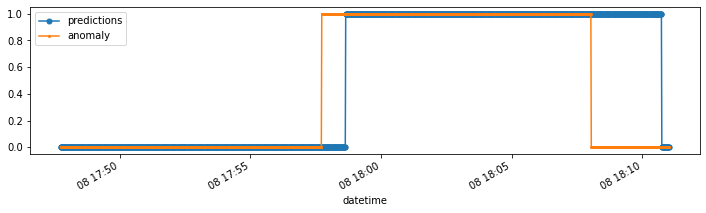

In [33]:
true_outlier = [df.anomaly for df in list_of_df]
predicted_outlier[1].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

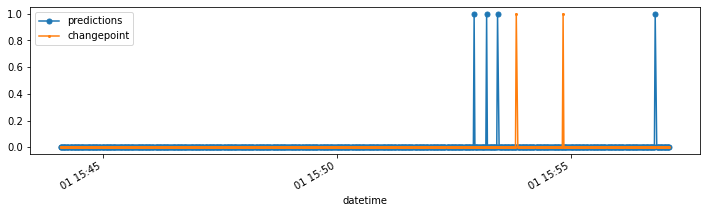

In [25]:
true_cp = [df.changepoint for df in list_of_df]
predicted_cp[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [16]:
import pandas as pd
import numpy as np

def evaluating_change_point(true, prediction, metric='nab', numenta_time=None):
    """
    true - both:
                list of pandas Series with binary int labels
                pandas Series with binary int labels
    prediction - both:
                      list of pandas Series with binary int labels
                      pandas Series with binary int labels
    metric: 'nab', 'binary' (FAR, MAR), 'average_delay'
                
    """
    
    def binary(true, prediction):      
        """
        true - true binary series with 1 as anomalies
        prediction - trupredicted binary series with 1 as anomalies
        """
        def single_binary(true,prediction):
            true_ = true == 1 
            prediction_ = prediction == 1
            TP = (true_ & prediction_).sum()
            TN = (~true_ & ~prediction_).sum()
            FP = (~true_ & prediction_).sum()
            FN = (true_ & ~prediction_).sum()
            return TP,TN,FP,FN
            
        if type(true) != type(list()):
            TP,TN,FP,FN = single_binary(true,prediction)
        else:
            TP,TN,FP,FN = 0,0,0,0
            for i in range(len(true)):
                TP_,TN_,FP_,FN_ = single_binary(true[i],prediction[i])
                TP,TN,FP,FN = TP+TP_,TN+TN_,FP+FP_,FN+FN_       
    
        f1 = round(TP/(TP+(FN+FP)/2), 2)
        print(f'False Alarm Rate {round(FP/(FP+TN)*100,2)} %' )
        print(f'Missing Alarm Rate {round(FN/(FN+TP)*100,2)} %')
        print(f'F1 metric {f1}')
        return f1
    
    def average_delay(detecting_boundaries, prediction):
        
        def single_average_delay(detecting_boundaries, prediction):
            missing = 0
            detectHistory = []
            for couple in detecting_boundaries:
                t1 = couple[0]
                t2 = couple[1]
                if prediction[t1:t2].sum()==0:
                    missing+=1
                else:
                    detectHistory.append(prediction[prediction ==1][t1:t2].index[0]-t1)
            return missing, detectHistory
            
        
        if type(prediction) != type(list()):
            missing, detectHistory = single_average_delay(detecting_boundaries, prediction)
        else:
            missing, detectHistory = 0, []
            for i in range(len(prediction)):
                missing_, detectHistory_ = single_average_delay(detecting_boundaries[i], prediction[i])
                missing, detectHistory = missing+missing_, detectHistory+detectHistory_

        add = pd.Series(detectHistory).mean()
        print('Average delay', add)
        print(f'A number of missed CPs = {missing}')
        return add
    
    def evaluate_nab(detecting_boundaries, prediction, table_of_coef=None):
        """
        Scoring labeled time series by means of
        Numenta Anomaly Benchmark methodics
        Parameters
        ----------
        detecting_boundaries: list of list of two float values
            The list of lists of left and right boundary indices
            for scoring results of labeling
        prediction: pd.Series with timestamp indices, in which 1 
            is change point, and 0 in other case. 
        table_of_coef: pandas array (3x4) of float values
            Table of coefficients for NAB score function
            indeces: 'Standart','LowFP','LowFN'
            columns:'A_tp','A_fp','A_tn','A_fn'
        Returns
        -------
        Scores: numpy array, shape of 3, float
            Score for 'Standart','LowFP','LowFN' profile 
        Scores_null: numpy array, shape 3, float
            Null score for 'Standart','LowFP','LowFN' profile             
        Scores_perfect: numpy array, shape 3, float
            Perfect Score for 'Standart','LowFP','LowFN' profile  
        """
        def single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=None, name_of_dataset=None):
            if table_of_coef is None:
                table_of_coef = pd.DataFrame([[1.0,-0.11,1.0,-1.0],
                                     [1.0,-0.22,1.0,-1.0],
                                      [1.0,-0.11,1.0,-2.0]])
                table_of_coef.index = ['Standart','LowFP','LowFN']
                table_of_coef.index.name = "Metric"
                table_of_coef.columns = ['A_tp','A_fp','A_tn','A_fn']

            alist = detecting_boundaries.copy()
            prediction = prediction.copy()

            Scores, Scores_perfect, Scores_null=[], [], []
            for profile in ['Standart', 'LowFP', 'LowFN']:       
                A_tp = table_of_coef['A_tp'][profile]
                A_fp = table_of_coef['A_fp'][profile]
                A_fn = table_of_coef['A_fn'][profile]
                def sigm_scale(y, A_tp, A_fp, window=1):
                    return (A_tp-A_fp)*(1/(1+np.exp(5*y/window))) + A_fp

                #First part
                score = 0
                if len(alist)>0:
                    score += prediction[:alist[0][0]].sum()*A_fp
                else:
                    score += prediction.sum()*A_fp
                #second part
                for i in range(len(alist)):
                    if i<=len(alist)-2:
                        win_space = prediction[alist[i][0]:alist[i+1][0]].copy()
                    else:
                        win_space = prediction[alist[i][0]:].copy()
                    win_fault = prediction[alist[i][0]:alist[i][1]]
                    slow_width = int(len(win_fault)/4)

                    if len(win_fault) + slow_width >= len(win_space):
                        print(f'Intersection of the windows of too wide widths for dataset {name_of_dataset}')
                        win_fault_slow = win_fault.copy()
                    else:
                        win_fault_slow= win_space[:len(win_fault)  +  slow_width]

                    win_fp = win_space[-len(win_fault_slow):]

                    if win_fault_slow.sum() == 0:
                        score+=A_fn
                    else:
                        #to get the first index
                        tr = pd.Series(win_fault_slow.values,index = range(-len(win_fault), len(win_fault_slow)-len(win_fault)))
                        tr_values= tr[tr==1].index[0]
                        tr_score = sigm_scale(tr_values, A_tp,A_fp,slow_width)
                        score += tr_score
                        score += win_fp.sum()*A_fp
                Scores.append(score)
                Scores_perfect.append(len(alist)*A_tp)
                Scores_null.append(len(alist)*A_fn)
            return np.array([np.array(Scores),np.array(Scores_null), np.array(Scores_perfect)])
       #======      
        if type(prediction) != type(list()):
            matrix = single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=table_of_coef)
        else:
            matrix = np.zeros((3,3))
            for i in range(len(prediction)):
                matrix_ = single_evaluate_nab(detecting_boundaries[i], prediction[i], table_of_coef=table_of_coef,name_of_dataset=i)
                matrix = matrix + matrix_      
                
        results = {}
        desc = ['Standart', 'LowFP', 'LowFN'] 
        for t, profile_name in enumerate(desc):
            results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
            print(profile_name,' - ', results[profile_name])
        
        return results
            
            
    #=========================================================================
    if type(true) != type(list()):
        true_items = true[true==1].index
    else:
        true_items = [true[i][true[i]==1].index for i in range(len(true))]
        

    if not metric=='binary':
        def single_detecting_boundaries(true, numenta_time, true_items):
            detecting_boundaries=[]
            td = pd.Timedelta(numenta_time) if numenta_time is not None else pd.Timedelta((true.index[-1]-true.index[0])/len(true_items))  
            for val in true_items:
                detecting_boundaries.append([val, val + td])
            return detecting_boundaries
        
        if type(true) != type(list()):
            detecting_boundaries = single_detecting_boundaries(true=true, numenta_time=numenta_time, true_items=true_items)
        else:
            detecting_boundaries=[]
            for i in range(len(true)):
                detecting_boundaries.append(single_detecting_boundaries(true=true[i], numenta_time=numenta_time, true_items=true_items[i]))

    if metric== 'nab':
        return evaluate_nab(detecting_boundaries, prediction)
    elif metric=='average_delay':
        return average_delay(detecting_boundaries, prediction)
    elif metric== 'binary':
        return binary(true, prediction)

In [27]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier[:23], predicted_outlier[:23], metric='binary', numenta_time='30 sec')

False Alarm Rate 9.12 %
Missing Alarm Rate 34.23 %
F1 metric 0.72
